In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov  9 23:28:04 2023

@author: dinglin
"""

import ray
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import math
import random
import string
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
train_data_dir = "./data/train_data.npy"
test_data_dir = "./data/test_data.npy"

CLIENT_NUM = 100
E = 10
C = 0.04
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

In [3]:
train_data = np.load(train_data_dir, allow_pickle=True)
test_data = np.load(test_data_dir, allow_pickle=True)

In [4]:
def partition_data(idx):
    # Preprocessing
    local_data = train_data[idx]
    local_data["images"] = [image.flatten() for image in local_data["images"]]
    train_images, val_images, train_labels, val_labels = train_test_split(
    local_data["images"], local_data["labels"], test_size=0.2, random_state=42)
    return [train_images, val_images, train_labels, val_labels]

In [5]:
class MLP2(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(MLP2, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.dropout = nn.Dropout(p=0.1)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [6]:
def weighted_average(weights, client_results):
    loss_list = [weights[i]*client_results[i][0] for i in range(len(client_results))]
    acc_list = [weights[i]*client_results[i][1] for i in range(len(client_results))]
    return sum(loss_list)/sum(weights), sum(acc_list)/sum(weights)

def fedAvg(weights, train_results):
    models_weights = [train_results[i][2] for i in range(len(train_results))]
    weighted_averaged_weights = {}
    for param_name in models_weights[0]:
        param_tensors = [model[param_name] for model in models_weights]
        weighted_averaged_param = sum(weight * param / sum(weights) for weight, param in zip(weights, param_tensors))
        weighted_averaged_weights[param_name] = weighted_averaged_param
    return weighted_averaged_weights 

## Centralized Training

In [8]:
server_model = MLP2(28*28, 62).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(server_model.parameters(), lr=0.005, momentum=0.5)
raw_data = [partition_data(i) for i in range(100)]
processed_data = [list(chain(*[raw_data[j][i] for j in range(100)])) for i in range(4)]
train_image = np.array(processed_data[0])
valid_image = np.array(processed_data[1])
train_label = np.array(processed_data[2])
valid_label = np.array(processed_data[3])
idxes = [i for i in range(len(processed_data[0]))]
shuffled_list = random.sample(idxes, len(idxes))
batch_idx = [shuffled_list[i:min(i+32,len(idxes))] for i in range(0, len(idxes), 32)]
running_log = np.zeros((5000,4))
for i in range(5000):
    loss_i = []
    acc_i = []
    for b in range(len(batch_idx)):
        optimizer.zero_grad()
        bid = batch_idx[b]
        batch_x = train_image[bid]
        batch_y = train_label[bid]
        # forward + backward + optimize
        inputs = torch.FloatTensor(batch_x).to(device)
        labels = torch.tensor(batch_y,dtype=torch.int64).to(device)
        outputs = server_model(inputs)
        _, predicted = torch.max(outputs, 1)
        #print(torch.max(outputs, 1), labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        acc_ib = (predicted == labels).sum().item()/len(bid)
        loss_i.append(loss.item())
        acc_i.append(acc_ib)
    
    # validation
    batch_x = valid_image
    batch_y = valid_label
    inputs = torch.FloatTensor(batch_x).to(device)
    labels = torch.tensor(batch_y,dtype=torch.int64).to(device)
    outputs = server_model(inputs)
    _, predicted = torch.max(outputs, 1)
    acc = (predicted == labels).sum().item()/len(batch_y)
    loss = criterion(outputs, labels)
    # recording 
    running_log[i,0] = np.mean(loss_i)
    running_log[i,1] = np.mean(acc_i)
    running_log[i,2] = loss.item()
    running_log[i,3] = acc
    np.save("./central.npy", running_log)
    if i%100 == 0:
        print("Episode: {}".format(i) , "Training Loss: {}".format(np.mean(loss_i)), "Training Accuracy: {}".format(np.mean(acc_i)))
        print("Episode: {}".format(i) , "Validation Loss: {}".format(loss), "Validation Accuracy: {}".format(acc))

Episode: 0 Training Loss: 3.764014110625165 Training Accuracy: 0.05900943396226415
Episode: 0 Validation Loss: 3.710566282272339 Validation Accuracy: 0.0618073981582644
Episode: 100 Training Loss: 0.655284730705825 Training Accuracy: 0.8010455974842766
Episode: 100 Validation Loss: 0.8875738382339478 Validation Accuracy: 0.749492742313095
Episode: 200 Training Loss: 0.4575893762257864 Training Accuracy: 0.8486556603773585
Episode: 200 Validation Loss: 0.803266167640686 Validation Accuracy: 0.7724363976900266
Episode: 300 Training Loss: 0.3650635074425793 Training Accuracy: 0.8753537735849056
Episode: 300 Validation Loss: 0.7995281219482422 Validation Accuracy: 0.7841423443109099
Episode: 400 Training Loss: 0.30939599172967786 Training Accuracy: 0.8922091194968553
Episode: 400 Validation Loss: 0.8493532538414001 Validation Accuracy: 0.786951771499922
Episode: 500 Training Loss: 0.2797237182891219 Training Accuracy: 0.9024685534591195
Episode: 500 Validation Loss: 0.8878428339958191 Vali

In [17]:
test_image = test_data[0]["images"]
test_label = test_data[0]["labels"]
batch_x = np.array([image.flatten() for image in test_image])
batch_y = np.array(test_label)
inputs = torch.FloatTensor(batch_x).to(device)
labels = torch.tensor(batch_y,dtype=torch.int64).to(device)
outputs = server_model(inputs)
_, predicted = torch.max(outputs, 1)
acc = (predicted == labels).sum().item()/len(batch_y)
loss = criterion(outputs, labels)
print("Testing Loss: {}".format(loss), "Testing Accuracy: {}".format(acc))

Testing Loss: 1.3595765829086304 Testing Accuracy: 0.8011599005799502


In [7]:
import matplotlib.pyplot as plt

def plot_curve(results):
    epochs = [i for i in range(1,np.size(results,0)+1)]
    train_loss = results[:,0]
    train_accuracy = results[:,1]
    val_loss = results[:,2]
    val_accuracy = results[:,3]
    
    # Create a 2x2 subplot setting
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot Training Loss
    axs[0, 0].plot(epochs, train_loss, label='Training Loss')
    axs[0, 0].set_title('Training Loss')
    axs[0, 0].set_xlabel('Communication Rounds')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Plot Training Accuracy
    axs[0, 1].plot(epochs, train_accuracy, label='Training Accuracy')
    axs[0, 1].set_title('Training Accuracy')
    axs[0, 1].set_xlabel('Communication Rounds')
    axs[0, 1].set_ylabel('Accuracy (%)')
    axs[0, 1].legend()
    
    # Plot Validation Loss
    axs[1, 0].plot(epochs, val_loss, label='Validation Loss')
    axs[1, 0].set_title('Validation Loss')
    axs[1, 0].set_xlabel('Communication Rounds')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()

    # Plot Validation Accuracy
    axs[1, 1].plot(epochs, val_accuracy, label='Validation Accuracy')
    axs[1, 1].set_title('Validation Accuracy')
    axs[1, 1].set_xlabel('Communication Rounds')
    axs[1, 1].set_ylabel('Accuracy (%)')
    axs[1, 1].legend()

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Show the plot
    plt.show()

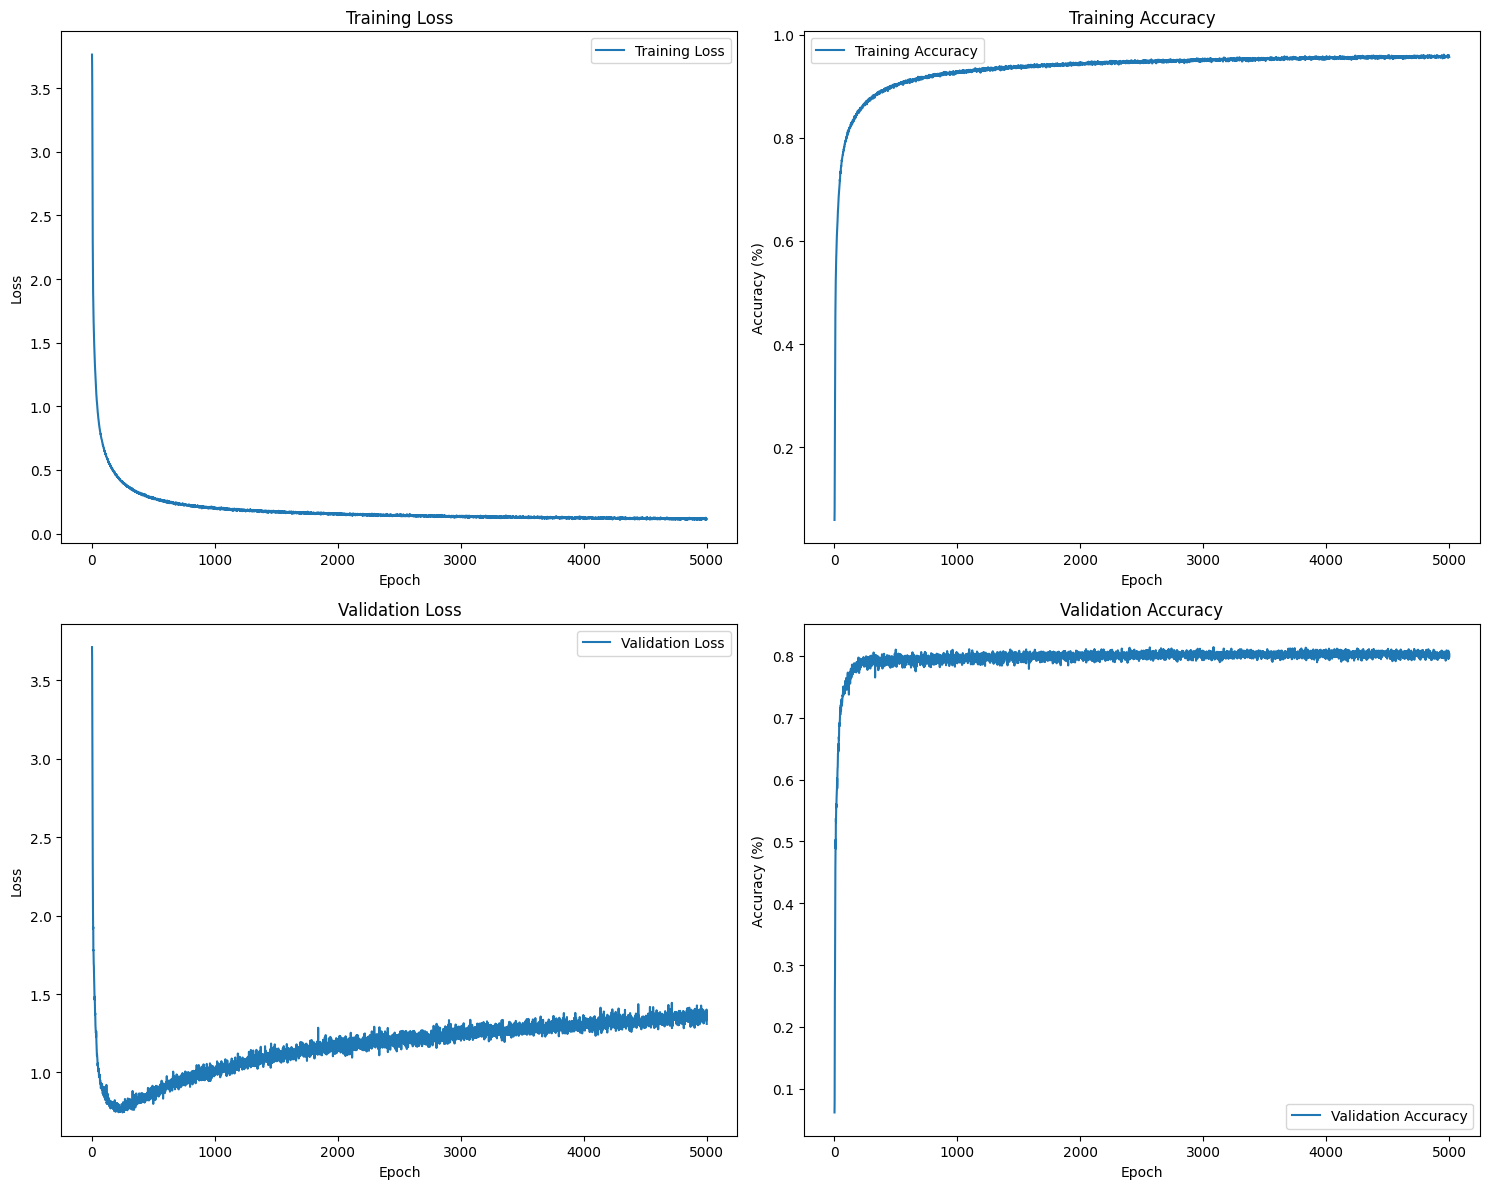

In [6]:
import numpy as np
import matplotlib.pyplot as plt

central_results = np.load("./central.npy")
plot_curve(central_results)

## FedAvg for EMNIST dataset (C=10)

In [15]:
def train_model(model, data, E):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    criterion = nn.CrossEntropyLoss()
    x_train = np.array(data[0])
    y_train = np.array(data[2])
    idxes = [i for i in range(len(y_train))]
    shuffled_list = random.sample(idxes, len(idxes))
    batch_idx = [shuffled_list[i:min(i+32,len(idxes))] for i in range(0, len(idxes), 32)]
    for e in range(E):
        total_correct = 0
        for b in range(len(batch_idx)):
            optimizer.zero_grad()
            bid = batch_idx[b]
            batch_x = x_train[bid]
            batch_y = y_train[bid]
        
            inputs = torch.FloatTensor(batch_x).to(device)
            labels = torch.tensor(batch_y,dtype=torch.int64).to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total_correct += correct

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #return loss.item(), total_correct/len(self.y_val), [self.model.layer1.weight, self.model.layer2.weight]
    return loss.item(), total_correct/len(y_train), model.state_dict()
    
def validate_model(model, data):
    x_val = data[0]
    y_val = data[1]
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        inputs = torch.FloatTensor(x_val).to(device)
        outputs = model(inputs) 
        labels = torch.tensor(y_val,dtype=torch.int64).to(device)
        val_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct = (predicted == labels).sum().item()
    return val_loss.item(), total_correct/len(y_val)

In [11]:
def fedavg_sim(C=0.1, E=1):
    data = [partition_data(i) for i in range(CLIENT_NUM)]
    weights = np.array([len(data[i][2]) for i in range(CLIENT_NUM)])
    weights = weights/sum(weights)
    clients = [MLP2(28*28, 62).to(device) for i in range(CLIENT_NUM)]
    servel_model = MLP2(28*28, 62).to(device)
    fed_results_10 = np.zeros((15000,4))
    for i in range(15000):
        sample_clients_id = random.sample([i for i in range(CLIENT_NUM)], int(CLIENT_NUM*C))
        weight_iter = weights[sample_clients_id]
        weight_iter = weight_iter/sum(weight_iter)
        train_results = []
        valid_results = []
        for idx in sample_clients_id:
            model_idx = clients[idx]
            data_idx = data[idx]
            train_results_idx = train_model(model_idx, data_idx, E)
            train_results.append(train_results_idx)
            valid_results_idx = validate_model(model_idx, [data_idx[1], data_idx[3]])
            valid_results.append(valid_results_idx)
        w_train_results = weighted_average(weight_iter, train_results)
        w_valid_results = weighted_average(weight_iter, valid_results)
        new_weights = fedAvg(weight_iter, train_results)
        for client in clients:
            client.load_state_dict(new_weights)
        fed_results_10[i,0] = w_train_results[0]
        fed_results_10[i,1] = w_train_results[1]
        fed_results_10[i,2] = w_valid_results[0]
        fed_results_10[i,3] = w_valid_results[1]
        if i%100 == 0:
            np.save("./fed_c{}e{}.npy".format(int(C*100),E), fed_results_10)
        if i%500 == 0:
            print("Episode: {}".format(i) , "Training Loss: {}".format(fed_results_10[i,0]), "Training Accuracy: {}".format(fed_results_10[i,1]))
            print("Episode: {}".format(i) , "Validation Loss: {}".format(fed_results_10[i,2]), "Validation Accuracy: {}".format(fed_results_10[i,3]))
    target_model = clients[0]
    torch.save(target_model.state_dict(), './model/fed_c{}e{}.pth'.format(int(C*100),E))
    return clients[0]

In [12]:
fedavg_sim(C=0.1)

Episode: 0 Training Loss: 4.087630422181817 Training Accuracy: 0.02669322709163347
Episode: 0 Validation Loss: 4.078073222133743 Validation Accuracy: 0.05706757231666357
Episode: 500 Training Loss: 3.2212466387893666 Training Accuracy: 0.16186340307935254
Episode: 500 Validation Loss: 3.29733995444399 Validation Accuracy: 0.142858509437575
Episode: 1000 Training Loss: 2.230148061675595 Training Accuracy: 0.39720171006607063
Episode: 1000 Validation Loss: 2.1959768591156927 Validation Accuracy: 0.38555244593713217
Episode: 1500 Training Loss: 1.7063814489946894 Training Accuracy: 0.5702094647013191
Episode: 1500 Validation Loss: 1.5650339684253336 Validation Accuracy: 0.5765197534723208
Episode: 2000 Training Loss: 1.132092546034352 Training Accuracy: 0.6490623804056641
Episode: 2000 Validation Loss: 1.3511782707129683 Validation Accuracy: 0.6134332126735659
Episode: 2500 Training Loss: 1.1364081144202383 Training Accuracy: 0.6632165605095542
Episode: 2500 Validation Loss: 1.25050125778

In [14]:
test_model = clients[0]
test_image = test_data[0]["images"]
test_image = [image.flatten() for image in test_image]
test_label = test_data[0]["labels"]
test_results = validate_model(test_model, [test_image, test_label])
print("Testing Loss: {}".format(test_results[0]), "Testing Accuracy: {}".format(test_results[1]))

Testing Loss: 0.7545945048332214 Testing Accuracy: 0.7986743993371996


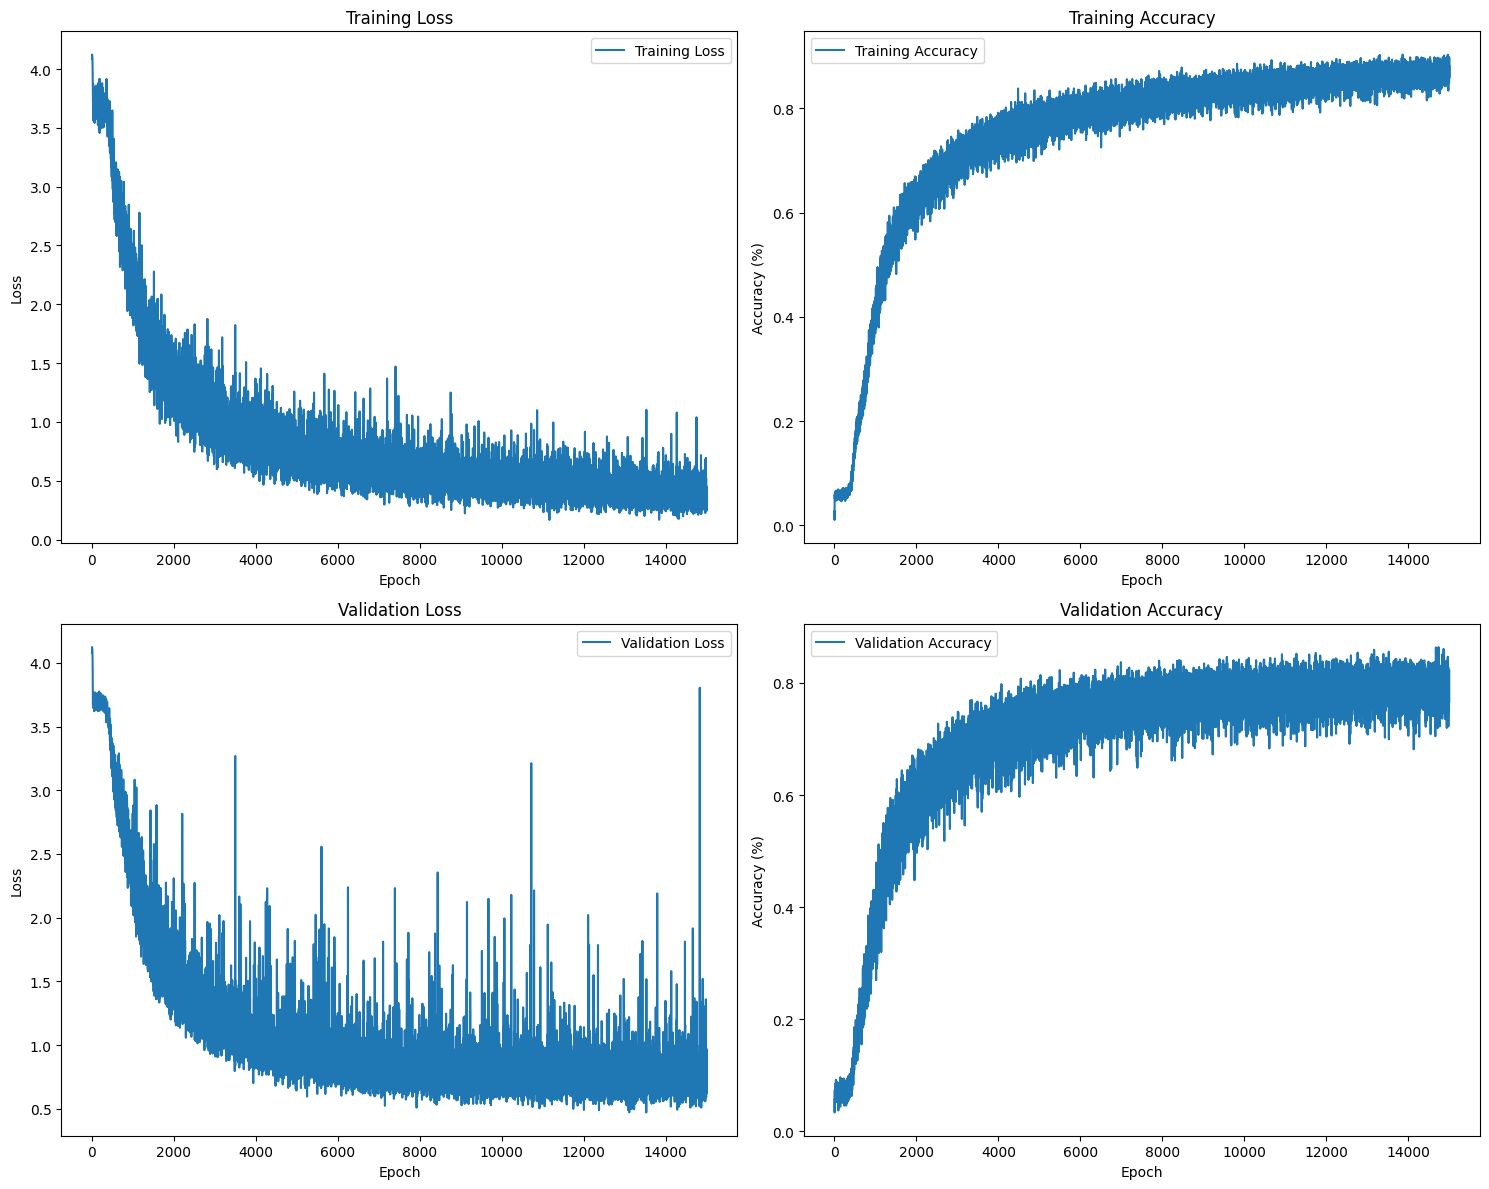

In [16]:
import numpy as np
import matplotlib.pyplot as plt

central_results = np.load("./fed_10.npy")
plot_curve(central_results)

## FedAvg for EMNIST dataset (C=5)

In [12]:
test_model = fedavg_sim(C=0.05)

Episode: 0 Training Loss: 4.052448005788656 Training Accuracy: 0.03282828282828283
Episode: 0 Validation Loss: 4.07855461382304 Validation Accuracy: 0.03319676107163304
Episode: 500 Training Loss: 2.388016758738337 Training Accuracy: 0.23626852659110723
Episode: 500 Validation Loss: 3.189014618772991 Validation Accuracy: 0.17708466887190796
Episode: 1000 Training Loss: 1.8174862197041513 Training Accuracy: 0.5108333333333333
Episode: 1000 Validation Loss: 1.9499662426114082 Validation Accuracy: 0.48027448758727176
Episode: 1500 Training Loss: 1.0788514122020367 Training Accuracy: 0.6193798449612403
Episode: 1500 Validation Loss: 1.4441016912460327 Validation Accuracy: 0.6190281133595087
Episode: 2000 Training Loss: 1.1857742376023528 Training Accuracy: 0.6723498888065232
Episode: 2000 Validation Loss: 1.1753179525074204 Validation Accuracy: 0.6646768941897138
Episode: 2500 Training Loss: 1.1718457713579071 Training Accuracy: 0.6595744680851062
Episode: 2500 Validation Loss: 1.311996079

In [7]:
test_image = test_data[0]["images"]
test_image = [image.flatten() for image in test_image]
test_label = test_data[0]["labels"]
test_results = validate_model(test_model, [test_image, test_label])
print("Testing Loss: {}".format(test_results[0]), "Testing Accuracy: {}".format(test_results[1]))

Testing Loss: 0.7140920729166997 Testing Accuracy: 0.8093675756227151


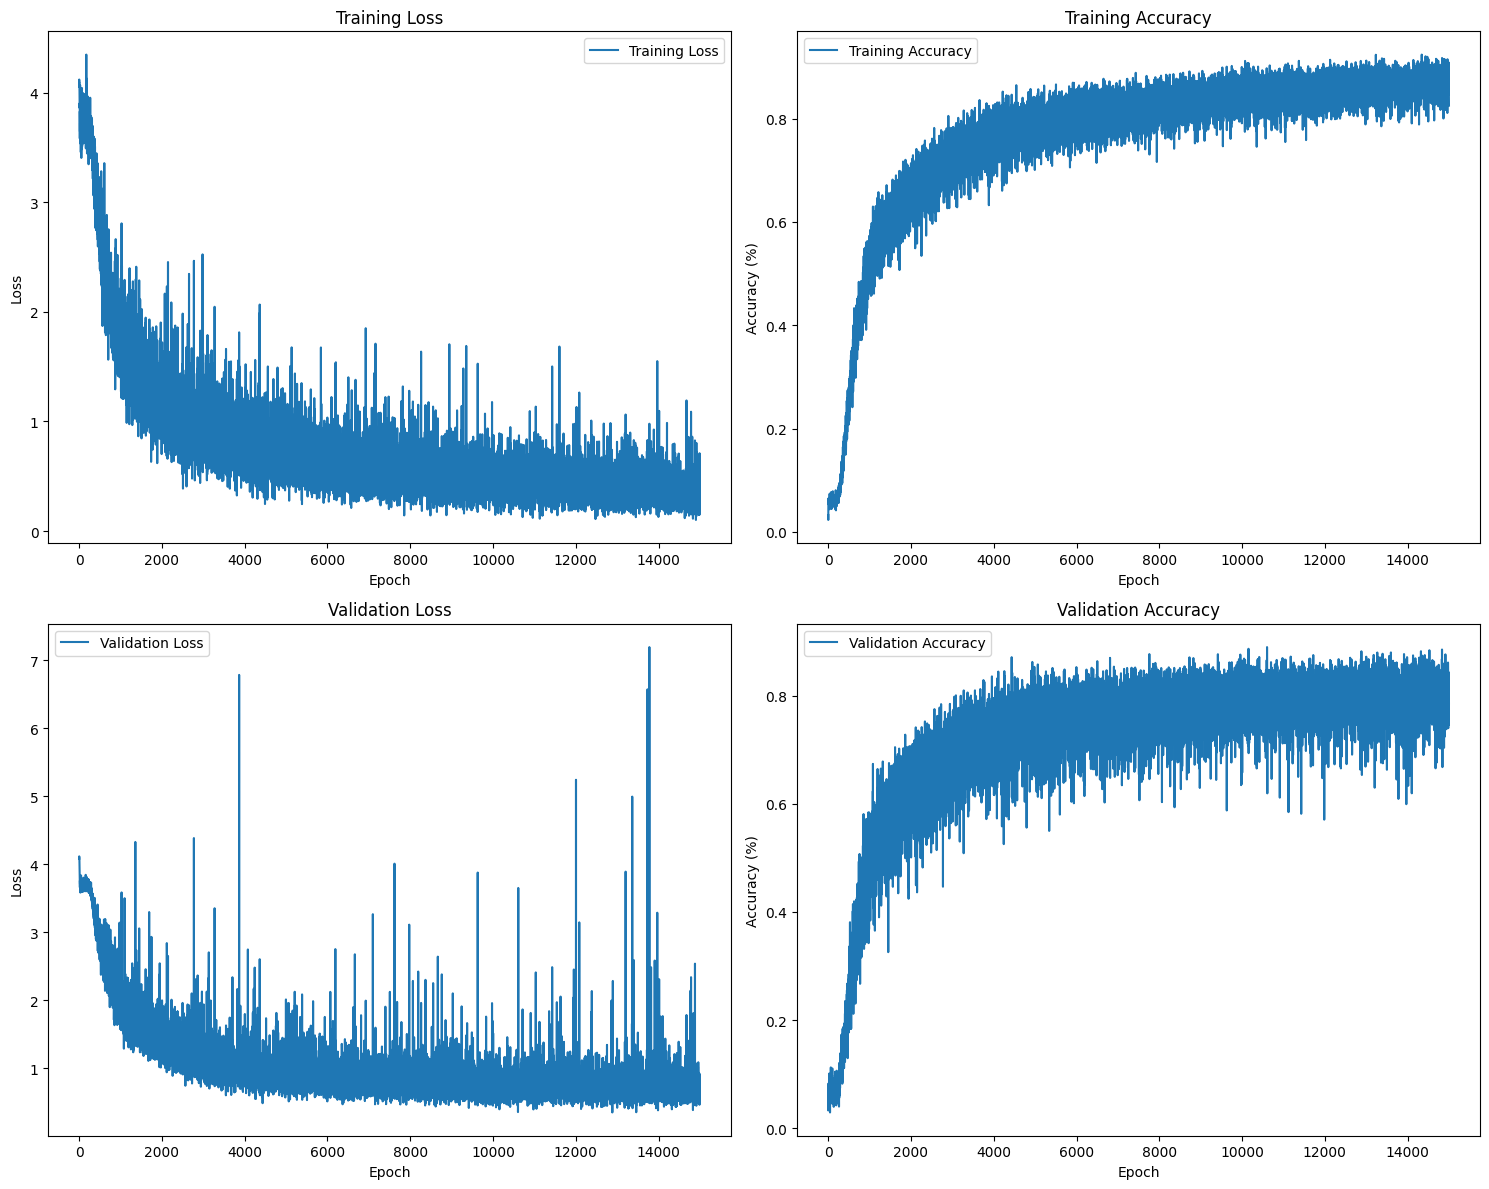

In [2]:
import numpy as np
import matplotlib.pyplot as plt

central_results = np.load("./fed_10.npy")
plot_curve(central_results)

## FedAvg for EMNIST 

In [10]:
test_model_c5e5 = fedavg_sim(C=0.05,E=5)

/tmp/ipykernel_1208101/3193091256.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020195/work/torch/csrc/utils/tensor_new.cpp:261.)
  inputs = torch.FloatTensor(x_val).to(device)


Episode: 0 Training Loss: 3.8652370165645316 Training Accuracy: 0.056672760511883
Episode: 0 Validation Loss: 3.8576074845176294 Validation Accuracy: 0.04693921733034598
Episode: 500 Training Loss: 0.6086490960089622 Training Accuracy: 0.8089639970609845
Episode: 500 Validation Loss: 1.0088685769793044 Validation Accuracy: 0.7397759690644479
Episode: 1000 Training Loss: 0.3099532406816808 Training Accuracy: 0.8577512776831346
Episode: 1000 Validation Loss: 0.8097333016549912 Validation Accuracy: 0.7676479966587854
Episode: 1500 Training Loss: 0.19945092868785735 Training Accuracy: 0.8840579710144927
Episode: 1500 Validation Loss: 0.8647538367868813 Validation Accuracy: 0.7455335859132095
Episode: 2000 Training Loss: 0.17095155371314705 Training Accuracy: 0.8962962962962964
Episode: 2000 Validation Loss: 1.0045307578373348 Validation Accuracy: 0.728894256575416
Episode: 2500 Training Loss: 0.10989831746539973 Training Accuracy: 0.9368600682593857
Episode: 2500 Validation Loss: 0.7264120

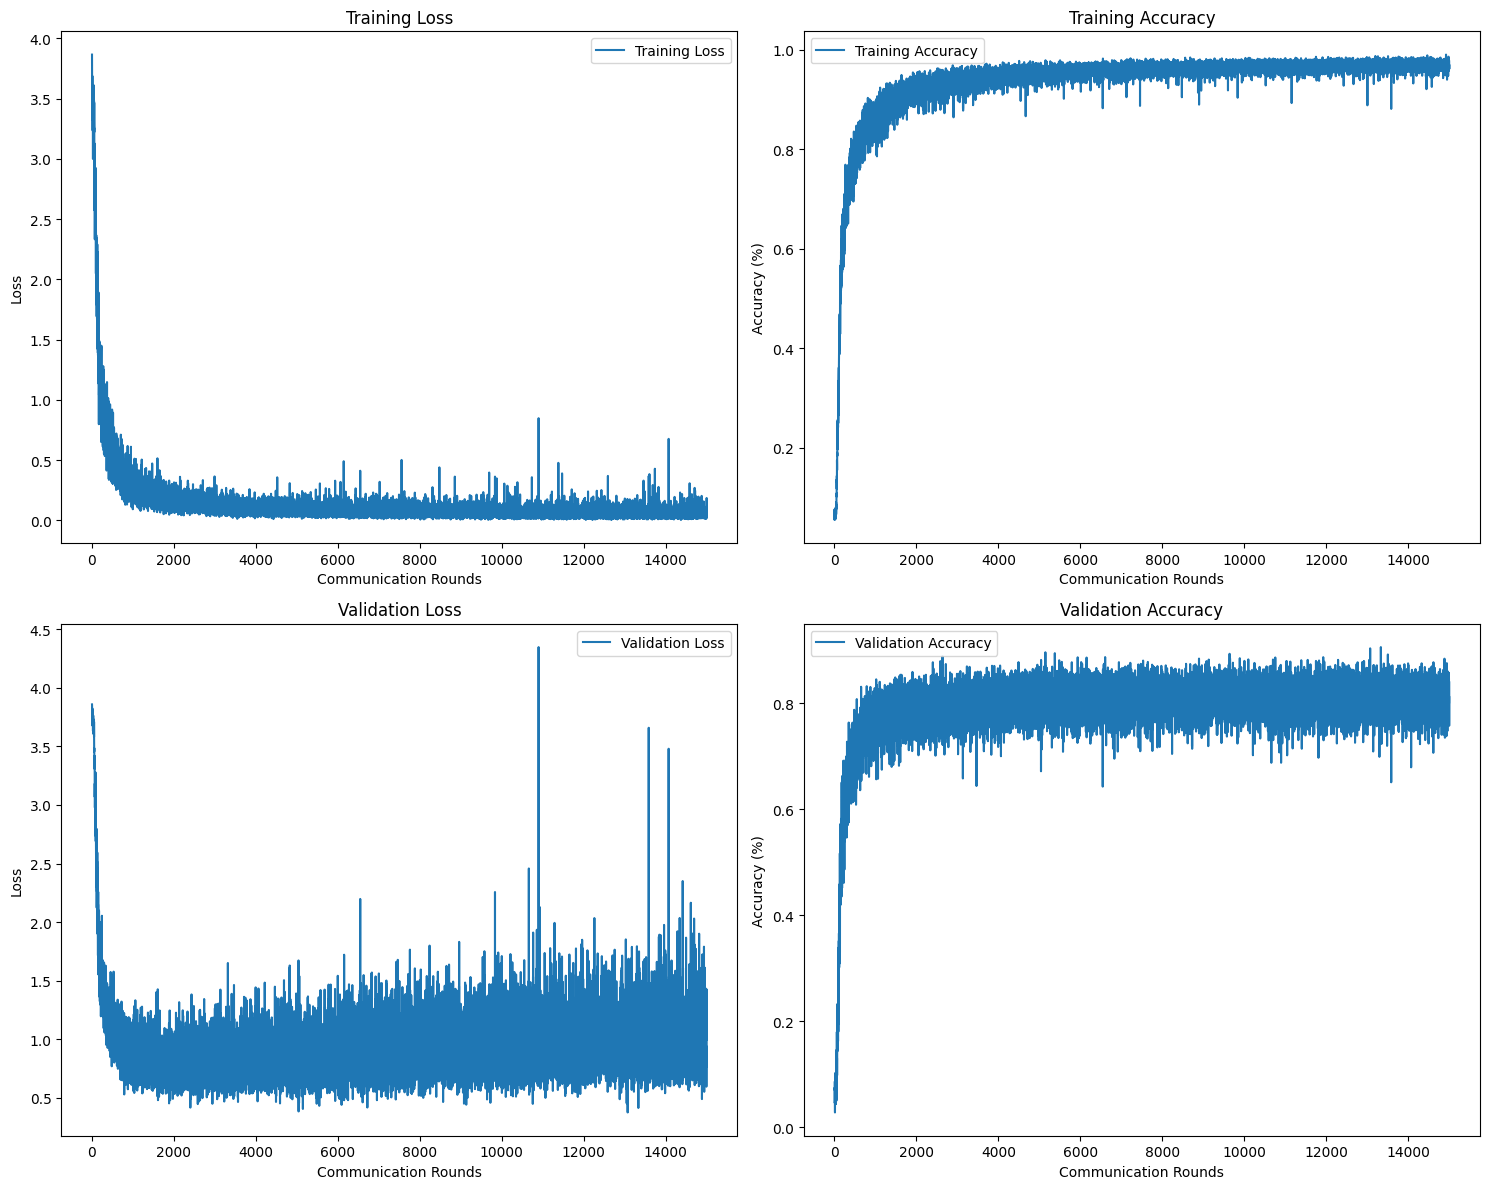

In [8]:
central_results = np.load("./fed_c5e5.npy")
plot_curve(central_results)

In [16]:
test_image = test_data[0]["images"]
test_image = [image.flatten() for image in test_image]
test_label = test_data[0]["labels"]
test_model = MLP2(28*28, 62).to(device)
test_model.load_state_dict(torch.load("./model/fed_c5e5.pth"))
test_results = validate_model(test_model, [test_image, test_label])
print("Testing Loss: {}".format(test_results[0]), "Testing Accuracy: {}".format(test_results[1]))

/tmp/ipykernel_331582/3193091256.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020195/work/torch/csrc/utils/tensor_new.cpp:261.)
  inputs = torch.FloatTensor(x_val).to(device)


Testing Loss: 1.132005214691162 Testing Accuracy: 0.8019884009942005


In [12]:
test_model_c2e1 = fedavg_sim(C=0.02,E=1)

Episode: 0 Training Loss: 4.069956436842502 Training Accuracy: 0.025948103792415175
Episode: 0 Validation Loss: 4.0436896021494615 Validation Accuracy: 0.023778529896728285
Episode: 500 Training Loss: 2.604774538314704 Training Accuracy: 0.40340909090909094
Episode: 500 Validation Loss: 2.6062831734166005 Validation Accuracy: 0.3079322638146168
Episode: 1000 Training Loss: 1.2761490291303343 Training Accuracy: 0.5315315315315317
Episode: 1000 Validation Loss: 1.8832185869818336 Validation Accuracy: 0.5057057057057057
Episode: 1500 Training Loss: 1.7591790868746524 Training Accuracy: 0.6181015452538632
Episode: 1500 Validation Loss: 1.4416426941259017 Validation Accuracy: 0.617389123018262
Episode: 2000 Training Loss: 1.5275105609853044 Training Accuracy: 0.5527065527065527
Episode: 2000 Validation Loss: 1.770818040921138 Validation Accuracy: 0.5615125615125616
Episode: 2500 Training Loss: 0.9407552223044087 Training Accuracy: 0.7250996015936255
Episode: 2500 Validation Loss: 1.29759421

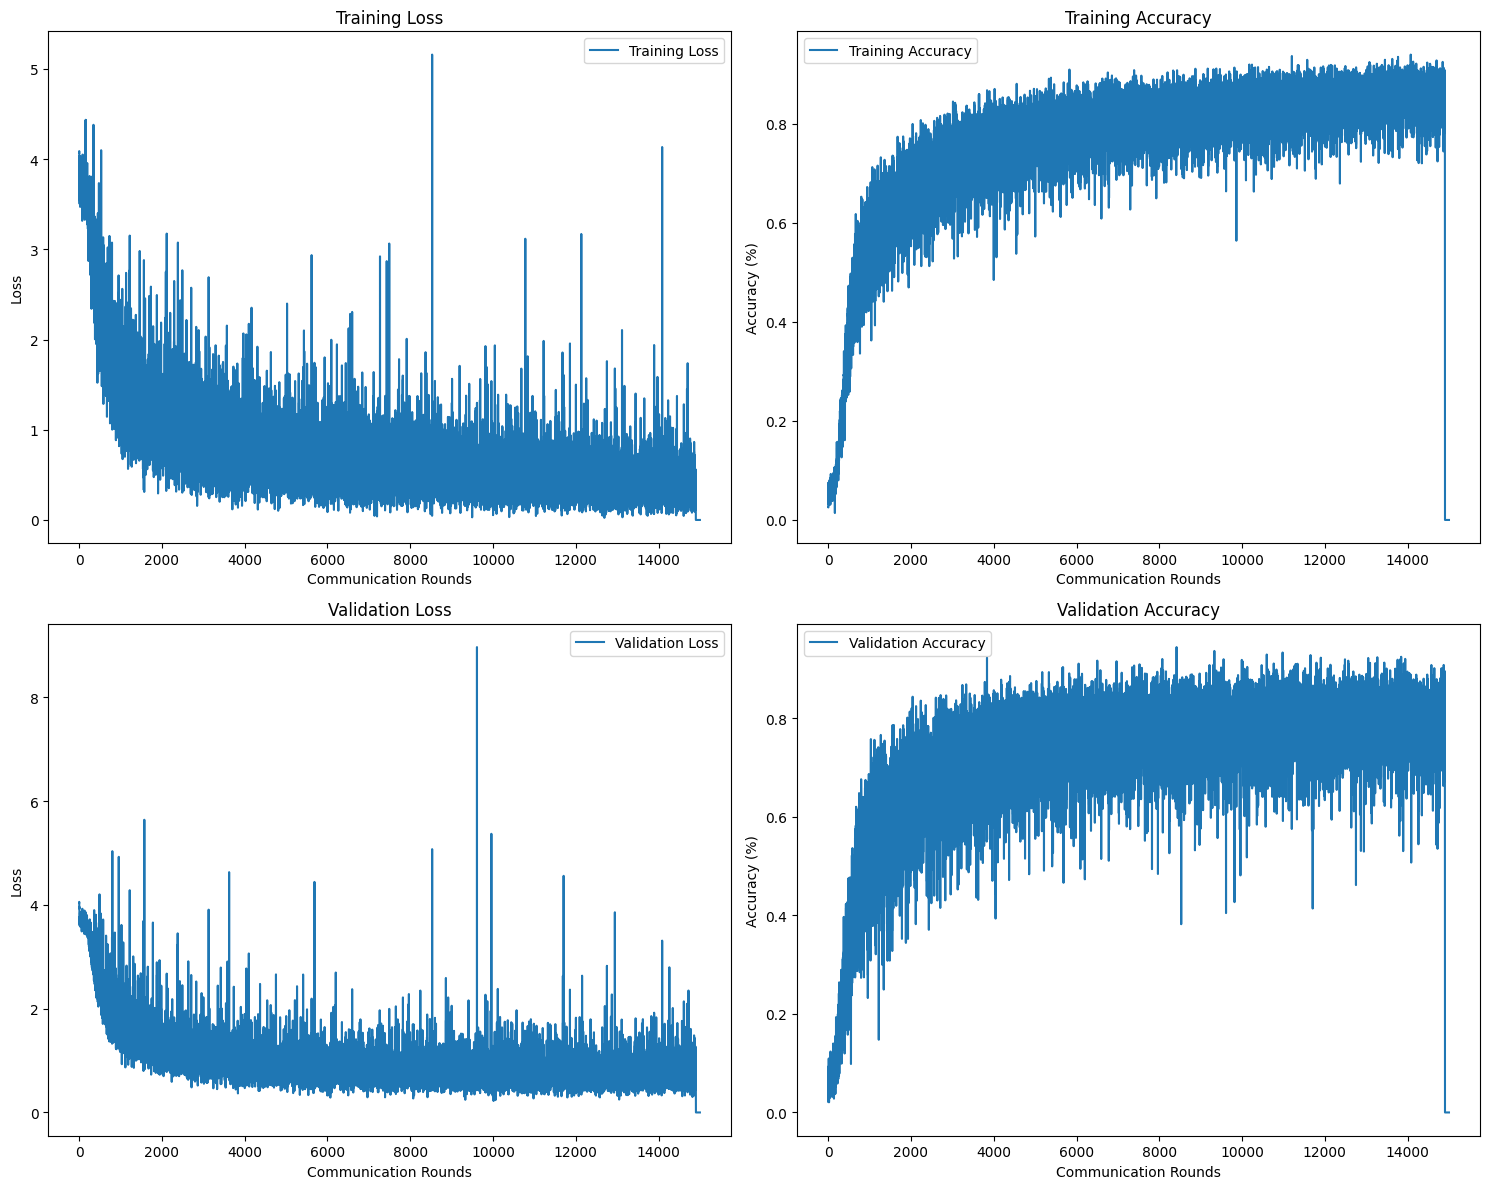

In [9]:
central_results = np.load("./fed_c2e1.npy")
plot_curve(central_results)

In [17]:
test_model.load_state_dict(torch.load("./model/fed_c2e1.pth"))
test_results = validate_model(test_model, [test_image, test_label])
print("Testing Loss: {}".format(test_results[0]), "Testing Accuracy: {}".format(test_results[1]))

Testing Loss: 0.8686277866363525 Testing Accuracy: 0.7688483844241922


In [13]:
test_model_c2e5 = fedavg_sim(C=0.02,E=5)

Episode: 0 Training Loss: 3.6473853933638423 Training Accuracy: 0.07065217391304349
Episode: 0 Validation Loss: 3.7291366673898003 Validation Accuracy: 0.05713677147953886
Episode: 500 Training Loss: 0.45573565774007685 Training Accuracy: 0.7889908256880735
Episode: 500 Validation Loss: 0.8343033495299315 Validation Accuracy: 0.6859327217125383
Episode: 1000 Training Loss: 0.290934159833717 Training Accuracy: 0.8507157464212679
Episode: 1000 Validation Loss: 0.8167925280783562 Validation Accuracy: 0.7661118581026629
Episode: 1500 Training Loss: 0.32972717722668754 Training Accuracy: 0.9170984455958548
Episode: 1500 Validation Loss: 0.7918129321412926 Validation Accuracy: 0.8012136839459324
Episode: 2000 Training Loss: 0.179889839787723 Training Accuracy: 0.9310986964618251
Episode: 2000 Validation Loss: 0.5216942655973595 Validation Accuracy: 0.8522346368715084
Episode: 2500 Training Loss: 0.1820251704301945 Training Accuracy: 0.9263565891472868
Episode: 2500 Validation Loss: 1.0272318

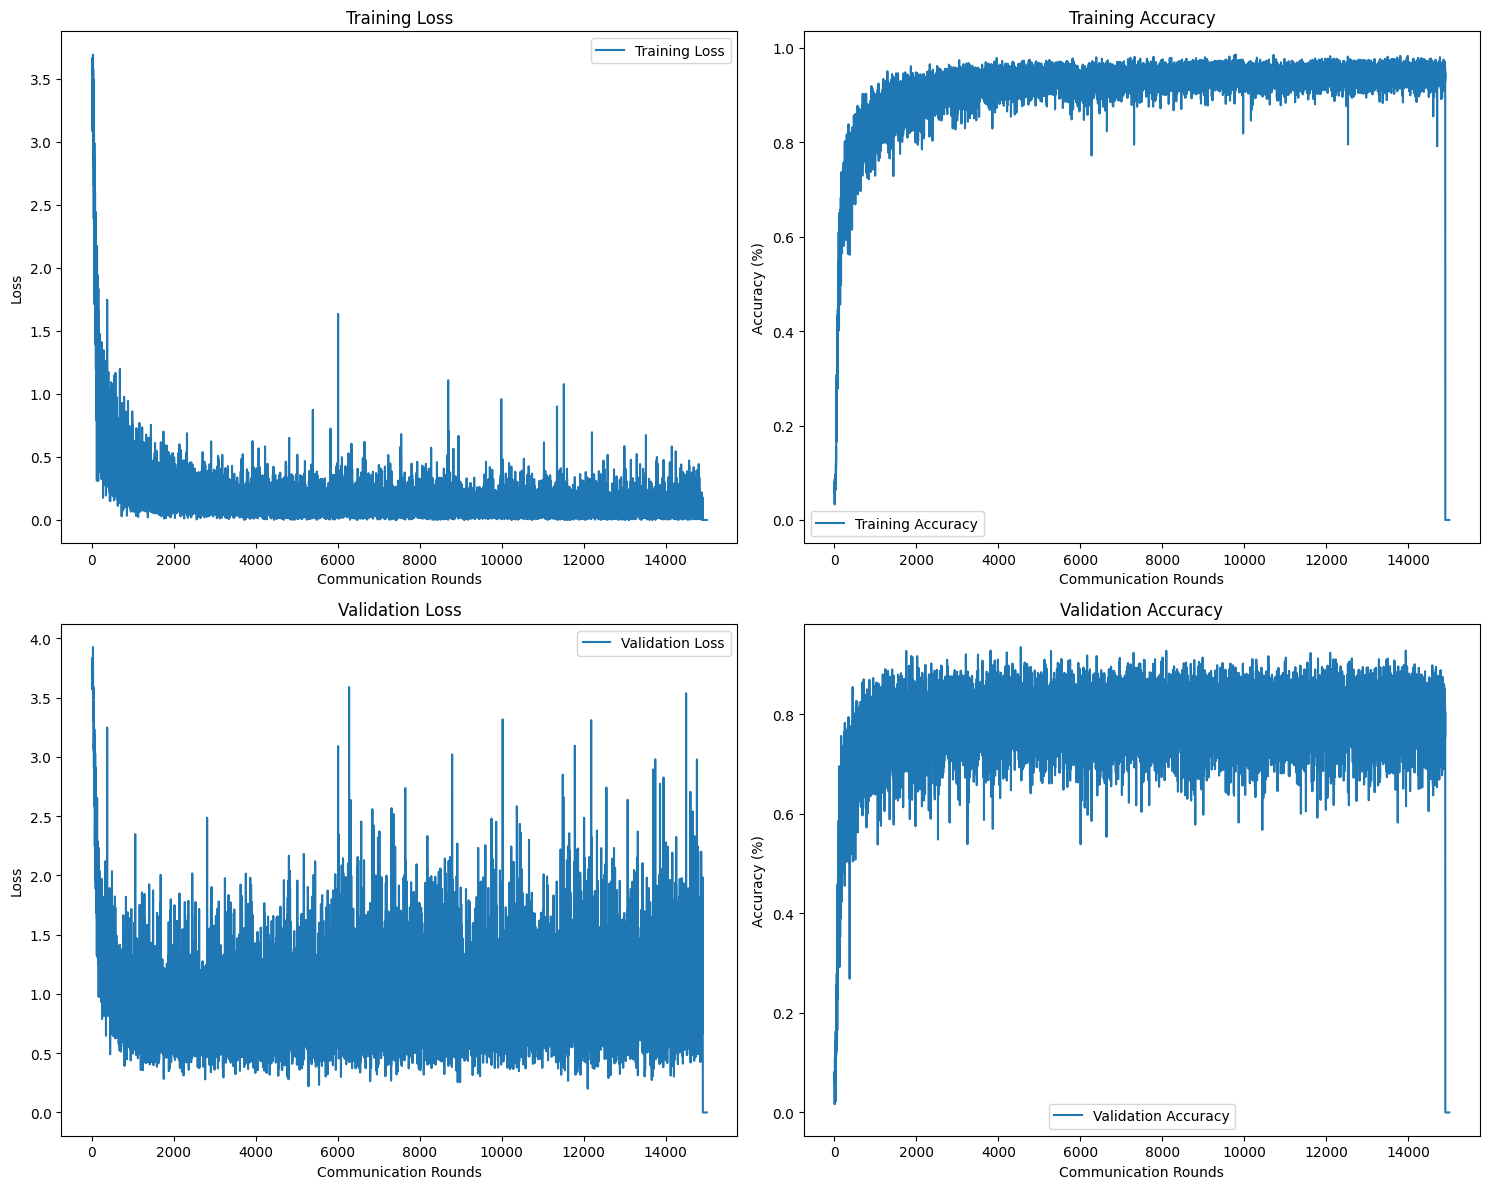

In [10]:
central_results = np.load("./fed_c2e5.npy")
plot_curve(central_results)

In [18]:
test_model.load_state_dict(torch.load("./model/fed_c2e5.pth"))
test_results = validate_model(test_model, [test_image, test_label])
print("Testing Loss: {}".format(test_results[0]), "Testing Accuracy: {}".format(test_results[1]))

Testing Loss: 1.2385886907577515 Testing Accuracy: 0.7671913835956918


In [12]:
test_model_c4e1 = fedavg_sim(C=0.04,E=1)

/tmp/ipykernel_2824143/3193091256.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020195/work/torch/csrc/utils/tensor_new.cpp:261.)
  inputs = torch.FloatTensor(x_val).to(device)


Episode: 0 Training Loss: 4.047106722208459 Training Accuracy: 0.03543307086614173
Episode: 0 Validation Loss: 4.066391509348952 Validation Accuracy: 0.05493640218049666
Episode: 500 Training Loss: 2.947448060809715 Training Accuracy: 0.1912464319695528
Episode: 500 Validation Loss: 2.94890851752175 Validation Accuracy: 0.20462626161459355
Episode: 1000 Training Loss: 2.1273723158135516 Training Accuracy: 0.45626690712353474
Episode: 1000 Validation Loss: 2.3290284385113593 Validation Accuracy: 0.3285671227037699
Episode: 1500 Training Loss: 1.5401939839096213 Training Accuracy: 0.5893027698185291
Episode: 1500 Validation Loss: 1.6027571840750796 Validation Accuracy: 0.5568841476204731
Episode: 2000 Training Loss: 1.600070432969423 Training Accuracy: 0.611368909512761
Episode: 2000 Validation Loss: 1.4074929543271697 Validation Accuracy: 0.6286643694207401
Episode: 2500 Training Loss: 1.226743480886732 Training Accuracy: 0.6217142857142857
Episode: 2500 Validation Loss: 1.3372911541802

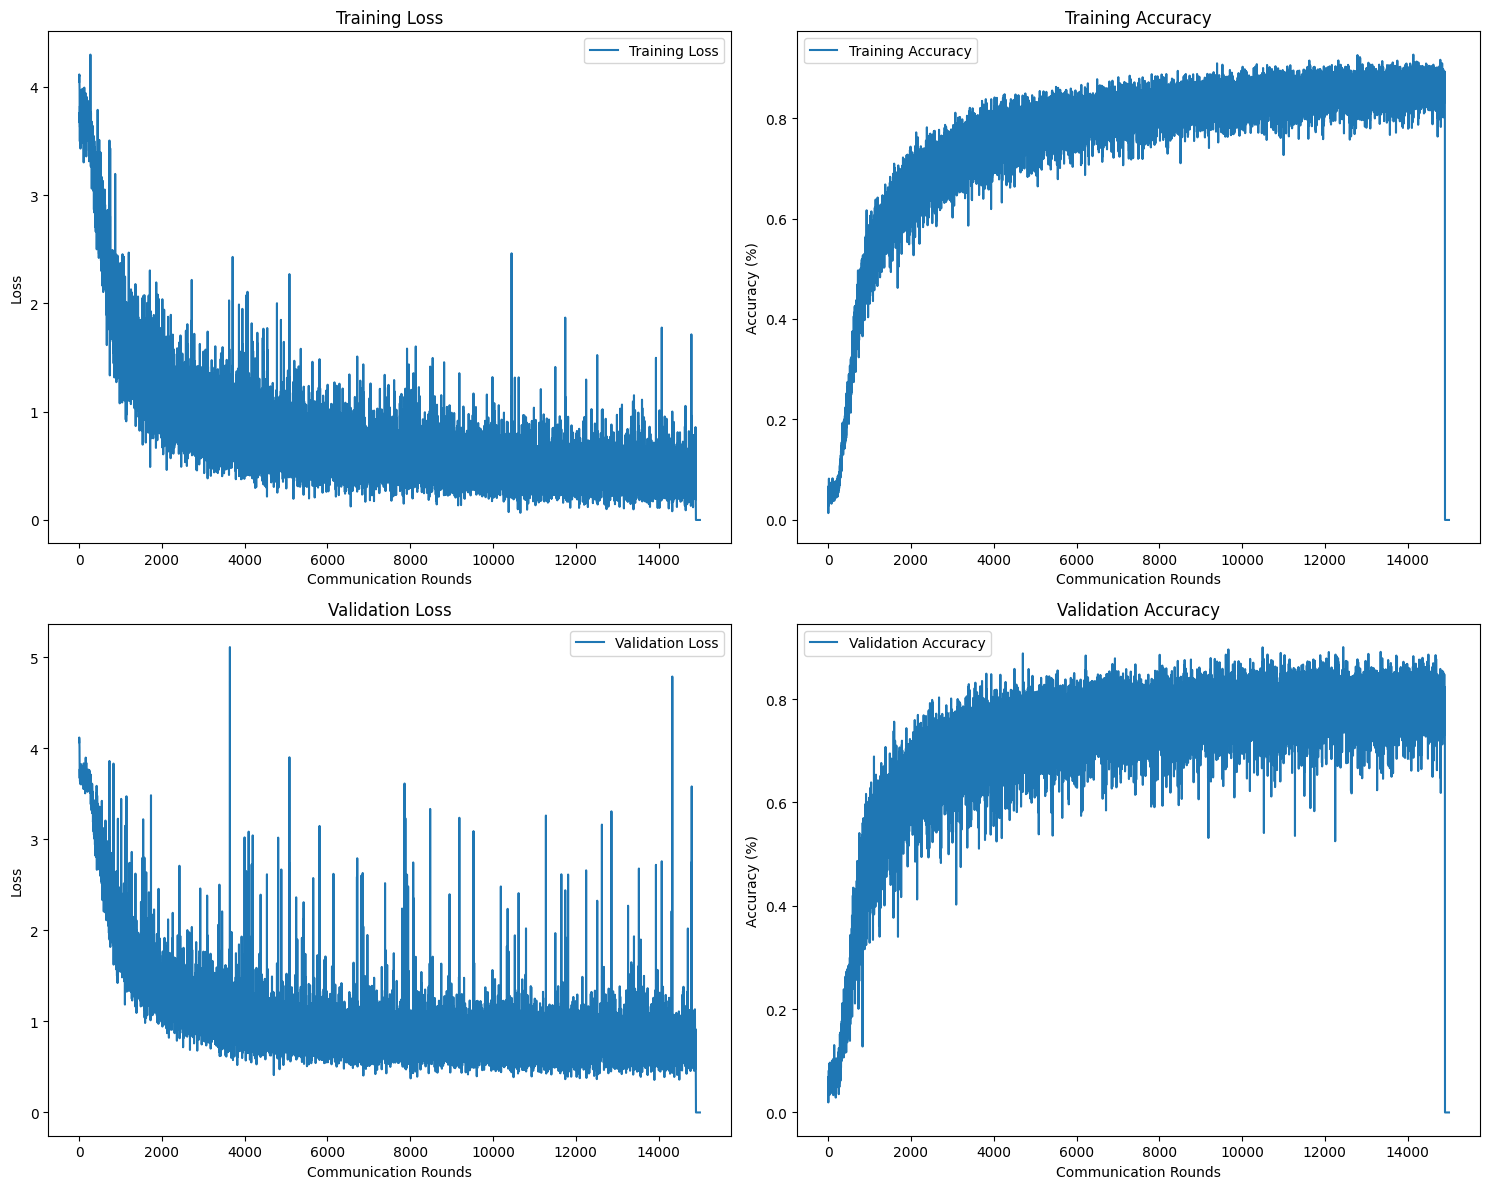

In [11]:
central_results = np.load("./fed_c4e1.npy")
plot_curve(central_results)

In [19]:
test_model.load_state_dict(torch.load("./model/fed_c4e1.pth"))
test_results = validate_model(test_model, [test_image, test_label])
print("Testing Loss: {}".format(test_results[0]), "Testing Accuracy: {}".format(test_results[1]))

Testing Loss: 0.8216457366943359 Testing Accuracy: 0.7823805578569456


In [ ]:
test_model_c4e1 = fedavg_sim(C=0.04,E=5)

Episode: 0 Training Loss: 3.641295392294894 Training Accuracy: 0.06515580736543909
Episode: 0 Validation Loss: 3.8897876894845504 Validation Accuracy: 0.045120733845946316
Episode: 500 Training Loss: 0.5738384075656922 Training Accuracy: 0.8126252505010021
Episode: 500 Validation Loss: 0.9529424749897095 Validation Accuracy: 0.7429776219104878
Episode: 1000 Training Loss: 0.2780379514217826 Training Accuracy: 0.8755890669180019
Episode: 1000 Validation Loss: 0.7668992979250124 Validation Accuracy: 0.8172187754580507
Episode: 1500 Training Loss: 0.080261405871982 Training Accuracy: 0.9112595419847327
Episode: 1500 Validation Loss: 0.7749859463167553 Validation Accuracy: 0.7918123405686067
Episode: 2000 Training Loss: 0.1561381875668183 Training Accuracy: 0.9080578512396695
Episode: 2000 Validation Loss: 0.8854921880709239 Validation Accuracy: 0.7868735348972502
Episode: 2500 Training Loss: 0.12243954840447481 Training Accuracy: 0.9093959731543625
Episode: 2500 Validation Loss: 0.8485199

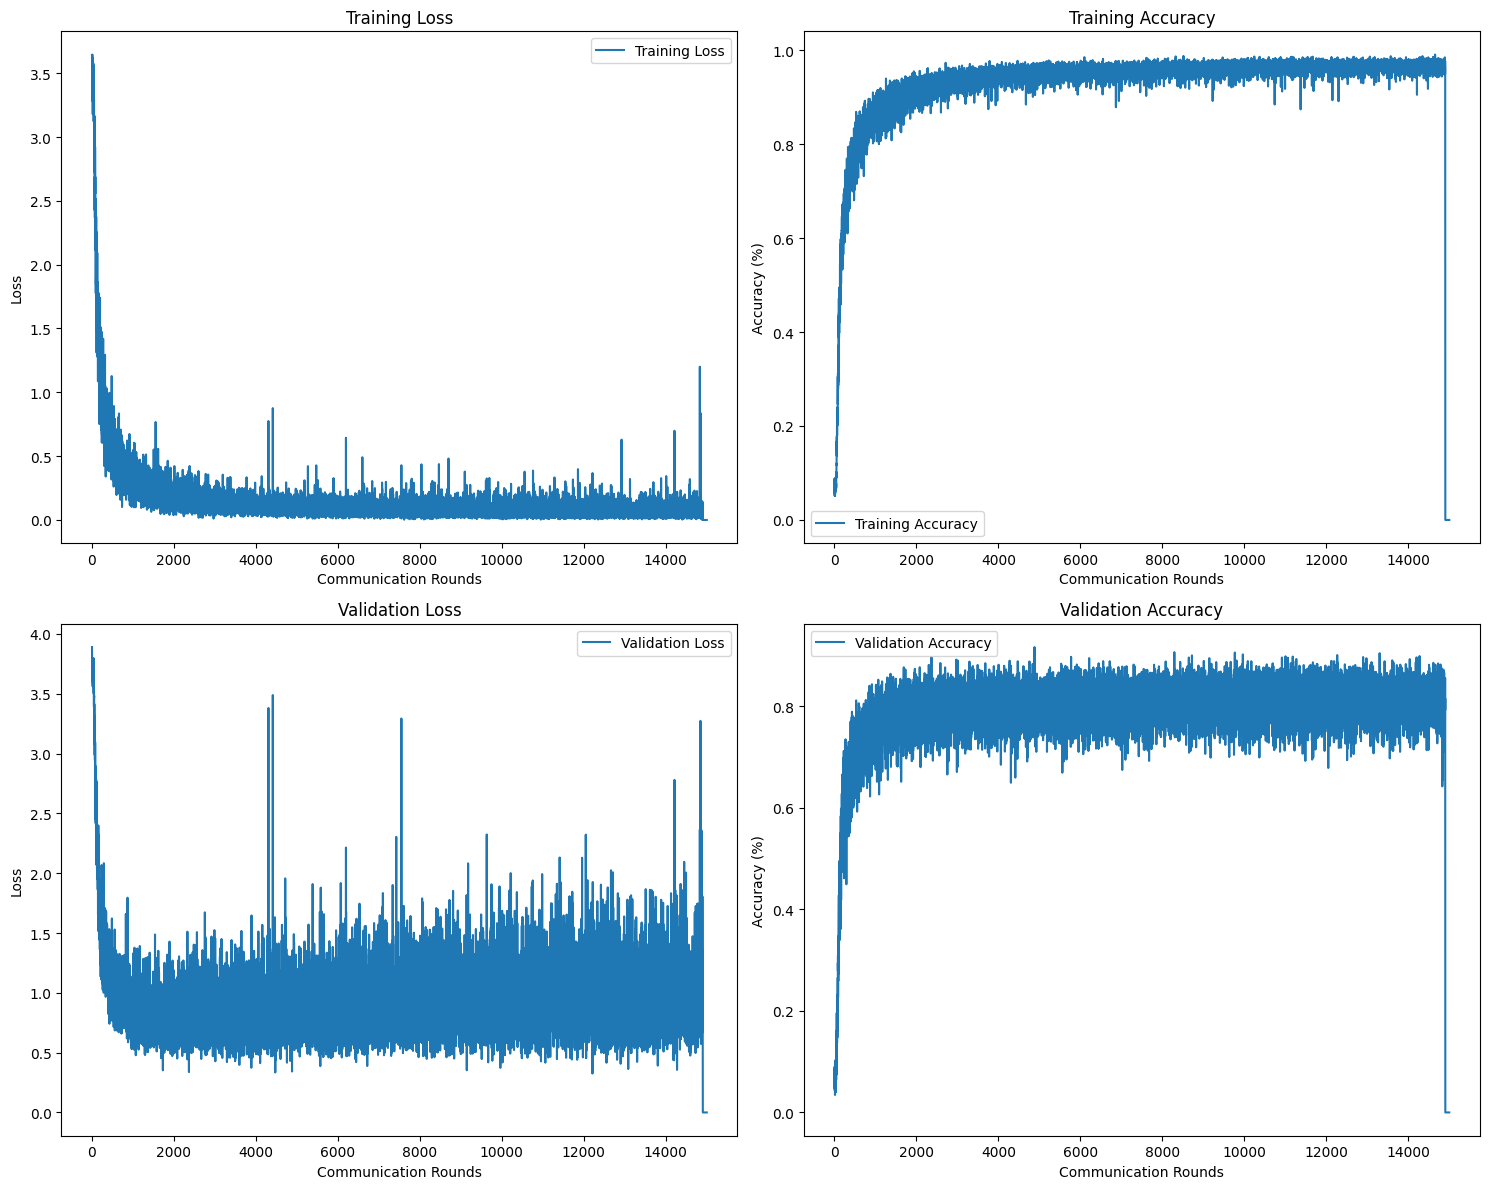

In [12]:
central_results = np.load("./fed_c4e5.npy")
plot_curve(central_results)

In [20]:
test_model.load_state_dict(torch.load("./model/fed_c4e5.pth"))
test_results = validate_model(test_model, [test_image, test_label])
print("Testing Loss: {}".format(test_results[0]), "Testing Accuracy: {}".format(test_results[1]))

Testing Loss: 1.1707040071487427 Testing Accuracy: 0.7914940624136979


## Parallel Clients

In [21]:
@ray.remote(num_cpus=1, num_gpus=1)
class Client:
    def __init__(self, local_data):
        self.E = E
        # Create model
        self.model = MLP2(28*28, 62).to(device)

        # Set data
        self.x_train = np.array(local_data[0])
        self.y_train = np.array(local_data[2])
        self.x_val = np.array(local_data[1])
        self.y_val = np.array(local_data[3])
        
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.005)
        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.CrossEntropyLoss()

    def train(self, global_weights = 0):
        # TODO: Perform E epochs of training using the local traininig data
        #self.model.layer1.weight.data = global_weights[0].clone()
        #self.model.layer2.weight.data = global_weights[1].clone()
        idxes = [i for i in range(len(self.y_train))]
        shuffled_list = random.sample(idxes, len(idxes))
        batch_idx = [shuffled_list[i:min(i+32,len(idxes))] for i in range(0, len(idxes), 32)]
        for i in range(self.E):
            for b in range(len(batch_idx)):
                self.optimizer.zero_grad()
                bid = batch_idx[b]
                batch_x = self.x_train[bid]
                batch_y = self.y_train[bid]
                # forward + backward + optimize
                inputs = torch.FloatTensor(batch_x).to(device)
                labels = torch.tensor(batch_y,dtype=torch.int64).to(device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_correct = (predicted == labels).sum().item()
                #print(torch.max(outputs, 1), labels)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
        #return loss.item(), total_correct/len(self.y_val), [self.model.layer1.weight, self.model.layer2.weight]
        return loss.item(), total_correct/len(self.y_val), self.model.state_dict()

    def evaluate(self):
        with torch.no_grad():
            
            inputs = torch.FloatTensor(self.x_val).to(device)
            outputs = self.model(inputs) 
            labels = torch.tensor(self.y_val,dtype=torch.int64).to(device)
            val_loss = self.criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total_correct = (predicted == labels).sum().item()
        return val_loss.item(), total_correct/len(self.y_val)
    
    def setNewWeight(self, weights):
        self.model.load_state_dict(weights)

In [ ]:
device = 'cuda'
ray.init(num_cpus=CLIENT_NUM)
data = [partition_data(i) for i in range(CLIENT_NUM)]
weights = np.array([len(data[i][0]) for i in range(CLIENT_NUM)])
weights = weights/sum(weights)
#clients = [Client.remote(data[i]) for i in range(CLIENT_NUM)]
server_model = MLP2(28*28, 62)
train_log = np.zeros((15000,4))
# train_log = np.load("./parallel_clients.npy")
# server_model.load_state_dict(torch.load("./model/parallel_clients.pth"))
for i in range(15000):
    sample_clients_id = random.sample([i for i in range(CLIENT_NUM)], int(CLIENT_NUM*C))
    sample_clients = [Client.remote(data[i]) for i in sample_clients_id]
    server_weight = server_model.state_dict()
    ray.get([client.setNewWeight.remote(server_weight) for client in sample_clients])
    weight_iter = weights[sample_clients_id]
    #global_weights = [server_model.layer1.weight, server_model.layer2.weight]
    train_results = ray.get([client.train.remote() for client in sample_clients])
    w_train_results = weighted_average(weight_iter, train_results)
    #train_result_list.append(w_train_results)
    valid_results = ray.get([client.evaluate.remote() for client in sample_clients])
    w_valid_results = weighted_average(weight_iter, valid_results)
    #valid_result_list.append(w_valid_results)
    train_log[i,0] = w_train_results[0]
    train_log[i,1] = w_train_results[1]
    train_log[i,2] = w_valid_results[0]
    train_log[i,3] = w_valid_results[1]
    new_weights = fedAvg(weight_iter, train_results)
    server_model.load_state_dict(new_weights)
    #ray.get([client.train.remote(new_weights) for client in clients])
    if i%100 == 0:
        np.save("./parallel_clients.npy", train_log)
        torch.save(server_model.state_dict(), "./model/parallel_clients.pth")
    if i%500 == 0:
        print("Episode: {}".format(i) , "Training Loss: {}".format(train_log[i,0]), "Training Accuracy: {}".format(train_log[i,1]))
        print("Episode: {}".format(i) , "Validation Loss: {}".format(train_log[i,2]), "Validation Accuracy: {}".format(train_log[i,3]))
        
ray.shutdown()

2023-11-15 23:00:36,912	INFO worker.py:1642 -- Started a local Ray instance.


Episode: 0 Training Loss: 3.7375821125607525 Training Accuracy: 0.029202713026242437
Episode: 0 Validation Loss: 3.923527477669115 Validation Accuracy: 0.05418567918567919


In [11]:
ray.shutdown()